In [133]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
class Env:
    def __init__(self, k, dynamic=False):
        self.k = k
        self.dynamic = dynamic
        self._Q_values = np.random.randn(k)

    def get_qvalue(self, action):
        return self._Q_values[action]

    def set_qvalue(self, action, value):
        self._Q_values[action] = value

    def possible_actions(self):
        return list(range(self.k))
    
    def take_action(self, action):
        reward = self.get_qvalue(action) + np.random.randn()
        if self.dynamic:
            self.update()
        return reward

    def update(self):
        self._Q_values+=np.random.normal(0, 0.01, (self.k,))

    def reset(self):
        self._Q_values = np.random.randn(self.k)

In [152]:
class EpsGreedyBandit:
    def __init__(self, n_actions, epsilon, step_size=None, initial_Q=0):
        self.possible_actions = range(n_actions)
        self.epsilon = epsilon
        self._Q_values = np.full((n_actions, ), initial_Q, dtype=float)
        self.sample_average = None
        self.alphas = np.empty((n_actions, ))
        if isinstance(step_size, float):
            self.sample_average = False
            self.alphas.fill(step_size)
        else:
            self.sample_average = True
            self.alphas.fill(1)

    def get_qvalue(self, action):
        return self._Q_values[action]

    def set_qvalue(self, action, value):
        self._Q_values[action] = value

    def get_best_action(self):
        best_action = max(
            self.possible_actions,
            key=lambda action: self.get_qvalue(action)
        )
        return best_action

    def get_action(self):
        epsilon = self.epsilon

        if np.random.random() < epsilon:
            chosen_action = np.random.choice(self.possible_actions)
        else:
            chosen_action = self.get_best_action()

        return chosen_action

    def update(self, action, reward):
        alpha = self.alphas[action]

        old_Q = self.get_qvalue(action)
        new_Q = old_Q + alpha*(reward - old_Q)

        self.set_qvalue(action, new_Q)
        if self.sample_average:
            self.alphas[action] = alpha / (alpha + 1)

In [153]:
def play_and_train(env, agent, t_max=10000):
    rewards = []
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action()

        r = env.take_action(a)
        agent.update(a, r)

        rewards.append(r)

    return rewards

In [158]:
k = 10
env = Env(k=k, dynamic=True)

eps = 0.1
agent_sample_avg = EpsGreedyBandit(n_actions=k, epsilon=eps, initial_Q=5.)
agent_constant_step = EpsGreedyBandit(n_actions=k, epsilon=eps, step_size=0.1, initial_Q=5.)

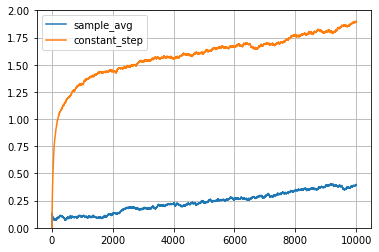

KeyboardInterrupt: ignored

In [159]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x).mean(axis=0)}).x.ewm(span=span).mean().values

rewards_sample_avg, rewards_constant_step = [], []

for i in range(2000):
    rewards_sample_avg.append(play_and_train(env, agent_sample_avg))
    rewards_constant_step.append(play_and_train(env, agent_constant_step))
    # Note: agent.epsilon stays constant

    if i % 50 == 0:
        clear_output(True)
        plt.plot(moving_average(rewards_sample_avg), label='sample_avg')
        plt.plot(moving_average(rewards_constant_step), label='constant_step')
        plt.grid()
        plt.legend()
        plt.ylim(0, 2)
        plt.show()